# T3 de NoIA

Neste trabalho, vamos aprender a utilizar duas técnicas diferentes de tradução automática, em que a primeira utilizará-se a estatística e, a segunda, Machine Learning na arquitetura codificador-decodificador.

Para que funcione corretamente, vá ao site https://www.statmt.org/europarl/ , encontre o link “parallel corpus Portuguese-English” o baixe e crie uma pasta "texts" e coloque os dois arquivos que serão baixados nessa pasta "texts "na raiz do projeto.

## Alunos
- **Arthur de Sá Antero - 212006577**
- **Arthur Mota Furtado - 200014935**

## Como rodar o projeto

Para rodar o projeto com aceleração de GPU, o d2l _não_ suporta o keras >= 3, logo, quando criar o ambiente virtual, use um comando como:

```bash
conda create -n d2l python=3.9 tensorflow[and-cuda] nltk -c forge -y
```

In [125]:
import re
from nltk.translate import IBMModel1, AlignedSent
from nltk.translate.bleu_score import sentence_bleu
import re
import tensorflow as tf
from d2l import tensorflow as d2l

# Carregamento de dados

Primeiro, carrega-se os textos baixados em duas matrizes, uma com tudo em português e, outra, com tudo em inglês. Cada um dos textos possuem textos do parlamento europeu nas duas línguas, tendo o mesmo conteúdo que nos ajudará a treinar um modelo de tradução.

In [126]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

file_en = "texts/europarl-v7.pt-en.en"
file_pt = "texts/europarl-v7.pt-en.pt"

with open(file_en, "r", encoding="utf-8") as f_en, open(file_pt, "r", encoding="utf-8") as f_pt:
    source_sentences = f_en.readlines()  # Inglês
    target_sentences = f_pt.readlines()  # Português

source_sentences = [clean_text(line.strip()).split() for line in source_sentences[:10000]]
target_sentences = [clean_text(line.strip()).split() for line in target_sentences[:10000]]

print("Inglês:", source_sentences[:5])
print("Português:", target_sentences[:5])

Inglês: [['resumption', 'of', 'the', 'session'], ['i', 'declare', 'resumed', 'the', 'session', 'of', 'the', 'european', 'parliament', 'adjourned', 'on', 'friday', '17', 'december', '1999', 'and', 'i', 'would', 'like', 'once', 'again', 'to', 'wish', 'you', 'a', 'happy', 'new', 'year', 'in', 'the', 'hope', 'that', 'you', 'enjoyed', 'a', 'pleasant', 'festive', 'period'], ['although', 'as', 'you', 'will', 'have', 'seen', 'the', 'dreaded', 'millennium', 'bug', 'failed', 'to', 'materialise', 'still', 'the', 'people', 'in', 'a', 'number', 'of', 'countries', 'suffered', 'a', 'series', 'of', 'natural', 'disasters', 'that', 'truly', 'were', 'dreadful'], ['you', 'have', 'requested', 'a', 'debate', 'on', 'this', 'subject', 'in', 'the', 'course', 'of', 'the', 'next', 'few', 'days', 'during', 'this', 'partsession'], ['in', 'the', 'meantime', 'i', 'should', 'like', 'to', 'observe', 'a', 'minute', 's', 'silence', 'as', 'a', 'number', 'of', 'members', 'have', 'requested', 'on', 'behalf', 'of', 'all', '

# IBM Model 1

O primeiro modelo que criaremos de tradução automática será puramente estatístico e simples chamado IBM Model 1, que basicamente aprenderá a olhar frase por frase dos dois textos que temos como dados, com a quantidade de frases que decidimos colocar para ele ler, e aprender a traduzir com base nessas duas línguas e cada frase traduzida nesses dois textos. Assim, o modelo ficará limitado a frases específicas do parlamento europeu, que pode ser um pouco formal demais e também fica limitado a uma certa quantidade de frases que decidimos que será treinado, pois pegar os dois textos inteiros demoraria muito.

In [127]:
bitext = [AlignedSent(target, source) for source, target in zip(source_sentences, target_sentences)]
print(bitext[:5])

ibm_model = IBMModel1(bitext, 5)

[AlignedSent(['reinício', 'da', 'sessão'], ['resumption', 'of', 'the', 'session'], Alignment([])), AlignedSent(['declaro', 'reaberta', 'a', 'sessão', 'do', 'parlamento', 'europeu', 'que', 'tinha', 'sido', 'interrompida', 'na', 'sextafeira', '17', 'de', 'dezembro', 'último', 'e', 'renovo', 'todos', 'os', 'meus', 'votos', 'esperando', 'que', 'tenham', 'tido', 'boas', 'férias'], ['i', 'declare', 'resumed', 'the', 'session', 'of', 'the', 'european', 'parliament', 'adjourned', 'on', 'friday', '17', 'december', '1999', 'and', 'i', 'would', 'like', 'once', 'again', 'to', 'wish', 'you', 'a', 'happy', 'new', 'year', 'in', 'the', 'hope', 'that', 'you', 'enjoyed', 'a', 'pleasant', 'festive', 'period'], Alignment([])), AlignedSent(['como', 'puderam', 'constatar', 'o', 'grande', 'bug', 'do', 'ano', '2000', 'não', 'aconteceu', 'em', 'contrapartida', 'os', 'cidadãos', 'de', 'alguns', 'dos', 'nossos', 'países', 'foram', 'vítimas', 'de', 'catástrofes', 'naturais', 'verdadeiramente', 'terríveis'], ['alt

# Avaliação

Para a avaliação das traduções, utilizou-se o BLEU, que pega a tradução feita e compara com a frase de referência e avalia em um valor de 0 a 1 o quão boa foi a tradução, em que 0 é que a tradução está completamente diferente da referência e 1 é que a tradução é idêntica a referência.

In [128]:

reference = [['this', 'is', 'a', 'test']]
candidate = ['this', 'is', 'a', 'trial']
score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
print(score)

0.75


A função a seguir traduz um texto que você passa a ela utilizando o IBM Model 1 que foi feito acima.

In [129]:
def translate_input(ibm_model, source_text):
    translated_words = []
    for source_word in source_text:
        max_prob = 0.0
        translated_word = None
        for target_word in ibm_model.translation_table[source_word]:
            prob = ibm_model.translation_table[source_word][target_word]
            if prob > max_prob:
                max_prob = prob
                translated_word = target_word
        if translated_word is not None:
            translated_words.append(translated_word)

    return translated_words

O trecho a seguir de código pega 100 frases dos próprios textos em que a IBM Model 1 foi treinada, as traduz e avalia as traduções utilizando o BLEU citado acima nas avaliações, fazendo uma média aritmética de todos os "scores" de tradução dado pelo BLEU.

In [141]:
file_en = "texts/europarl-v7.pt-en.en"
file_pt = "texts/europarl-v7.pt-en.pt"

with open(file_en, "r", encoding="utf-8") as f_en, open(file_pt, "r", encoding="utf-8") as f_pt:
    source_sentences = f_en.readlines()  # Inglês
    target_sentences = f_pt.readlines()  # Português

source_sentences = [clean_text(line.strip()).split() for line in source_sentences[10000:10100]]
target_sentences = [clean_text(line.strip()).split() for line in target_sentences[10000:10100]]

scores = []
for i in range(100):
  sentence = target_sentences[i]
  correct_sentence = source_sentences[i]
  translation = translate_input(ibm_model, sentence)
  scores.append(sentence_bleu([correct_sentence], translation,weights=(1, 0, 0, 0)))
score = sum(scores) / len(scores)
print(score)

/home/bomdia/miniconda3/envs/pls/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/bomdia/miniconda3/envs/pls/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/bomdia/miniconda3/envs/pls/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using 

0.2376933297120649


### Análise do resultado do modelo IBM Model 1

Como podemos ver, o resultado do modelo IBM é bem aquém do desejado, com um score blue médio por volta de 27%. Embora este valor seja bem baixo, o uso de sinônimos pode deixar o texto resultante bem compreensível. Ainda, considerando a quantidade de dados utilizados, e que o modelo usa um método puramente estatístico, o resultado do modelo é bom.

# Modelo Codificador - Decodificador

Para a última parte desse trabalho, faremos um modelo codificador-decodificador para comparar ao modelo feito anteriormente (IBM Model 1) usando como base o notebook encontrado no site da d2l na parte 10.7 (http://d2l.ai/chapter_recurrent-modern/seq2seq.html) mas o adaptando com a base de dados que temos que é diferente da usada na parte 10.5 do notebook (http://d2l.ai/chapter_recurrent-modern/machine-translation-and-dataset.html), que pega os dados diretamente da base de dados da d2l. Assim, podemos fazer o modelo de forma parecida para poder analisar a tradução.

Inicialmente declaramos a classe de dados a ser usada para o treinamento do modelo, que roda com 10000 sentenças de cada língua.

In [131]:
class MTEngPor(d2l.DataModule):  #@save
    """The English-Portuguese dataset."""
    def _download(self):
        file_en = "texts/europarl-v7.pt-en.en"
        file_pt = "texts/europarl-v7.pt-en.pt"

        with open(file_en, "r", encoding="utf-8") as f_en, open(file_pt, "r", encoding="utf-8") as f_pt:
            source_sentences = f_en.readlines()
            target_sentences = f_pt.readlines()

        source_sentences = source_sentences[:10000]
        target_sentences = target_sentences[:10000]

        return source_sentences, target_sentences

    def __init__(self, batch_size=128, num_steps=64, num_train=512, num_val=128):
        super(MTEngPor, self).__init__()
        self.save_hyperparameters()
        src, tgt = self._download()

        self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(
            src, tgt)
        
    def _build_array(self, sentences, vocab=None, is_tgt=False):
        pad_or_trim = lambda seq, t: (
            seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
        sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
        if is_tgt:
            sentences = [['<bos>'] + s for s in sentences]
        if vocab is None:
            vocab = d2l.Vocab(sentences, min_freq=2)
        array = tf.constant([vocab[s] for s in sentences])
        valid_len = tf.reduce_sum(
            tf.cast(array != vocab['<pad>'], tf.int32), 1)
        return array, vocab, valid_len

    def _build_arrays(self, src_text, tgt_text, src_vocab=None, tgt_vocab=None):

        src = [self._tokenize(self._preprocess(sentence)) for sentence in src_text]
        tgt = [self._tokenize(self._preprocess(sentence)) for sentence in tgt_text]

        src_array, src_vocab, src_valid_len = self._build_array(src, src_vocab)
        tgt_array, tgt_vocab, _ = self._build_array(tgt, tgt_vocab, True)
        return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]),
                src_vocab, tgt_vocab)


    def get_dataloader(self, train):
        idx = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader(self.arrays, train, idx)
    
    def _tokenize(self, text, max_examples=None):
        arr = text.split()
        arr.append("<eos>")
        return arr
    
    def build(self, src_sentences, tgt_sentences):
        raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(
            src_sentences, tgt_sentences)])
        arrays, _, _ = self._build_arrays(
            raw_text, self.src_vocab, self.tgt_vocab)
        return arrays
    
    def _preprocess(self, text):
        # Replace non-breaking space with space
        if type(text) is int:
            return ""
        text = text.replace('\u202f', ' ').replace('\xa0', ' ')
        # Insert space between words and punctuation marks
        no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
        out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
            for i, char in enumerate(text.lower())]
        return clean_text(''.join(out))

Em seguida, declaramos o encoder, decoder e o encoder-decoder. Todos esses são majoritariamente herdados das implementações feitas pelo d2l, sem tantas alterações.

In [132]:
class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence-to-sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(num_hiddens, num_layers, dropout)
    
    def call(self, X, *args):
        embs = self.embedding(tf.transpose(X))
        outputs, state = self.rnn(embs)
        return outputs, state

class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence-to-sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(num_hiddens, num_layers, dropout)
        self.dense = tf.keras.layers.Dense(vocab_size)
    
    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs
    
    def call(self, X, state):
        embs = self.embedding(tf.transpose(X))
        enc_output, hidden_state = state
        context = enc_output[-1]
        context = tf.tile(tf.expand_dims(context, 0), (embs.shape[0], 1, 1))
        embs_and_context = tf.concat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = tf.transpose(self.dense(outputs), (1, 0, 2))
        return outputs, [enc_output, hidden_state]

class Seq2Seq(d2l.EncoderDecoder):
    """The RNN encoder-decoder for sequence-to-sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()
    
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
    
    def configure_optimizers(self):
        return tf.keras.optimizers.Adam(learning_rate=self.lr)

Com as classes de dados e de estrutura da rede declarados, passamos para a fase do treinamento. Para isso, usamos a classe de dados previamente declarada, e a estrutura encoder-decorder, ambos com o mesmo tamanho e profundiade4s (2 camadas de 256 neurônios).

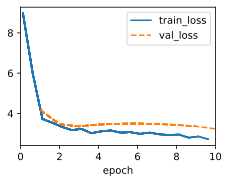

In [133]:
data = MTEngPor(batch_size=128)

embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2

with d2l.try_gpu():
    encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
    decoder = Seq2SeqDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
    model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)
    
trainer = d2l.Trainer(max_epochs=10, gradient_clip_val=1)
trainer.fit(model, data)


# Avaliação

Para a avaliação desse modelo, primeiro fizemos uma função para traduzir realmente traduzir as frases, para que, depois disso pudéssemos testar a sua eficácia em relação ao modelo anterior visto utilizando, também, um BLEU, assim como feito no modelo anteior.

In [134]:
@d2l.add_to_class(d2l.EncoderDecoder)
def predict_step(self, src, src_valid_len, num_steps,
                 save_attention_weights=False):
    """Predict tokens for a given source sentence."""
    enc_all_outputs = self.encoder(src, src_valid_len, training=False)

    dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
    
    # Shape of output: (batch_size, num_steps)
    output, attention_weights = [], []
    batch_size = src.shape[0]
    next_token = tf.expand_dims(tf.constant([0] * batch_size, dtype=tf.int64), axis=1) # Start with <bos> token


    for _ in range(num_steps):
        Y, dec_state = self.decoder(next_token, dec_state, training=False)
        predicted_token = tf.argmax(Y, axis=2, output_type=tf.int64)
        next_token = tf.cast(tf.expand_dims(tf.argmax(Y, axis=2), axis=1), tf.int64)  # Predict the next token
        output.append(predicted_token)
        if save_attention_weights:
            attention_weights.append(self.decoder.attention_weights)
        next_token = predicted_token # Use predicted token as next input


    return tf.concat(output, axis=1), attention_weights

In [135]:
@d2l.add_to_class(d2l.EncoderDecoder)
def translate(self, src_sentence, num_steps):
    """Translate a source sentence to target language."""
    data = MTEngPor(batch_size=128)
    src, _, src_valid_len = data._build_array([src_sentence], data.src_vocab)
    tgt_vocab = data.tgt_vocab
    pred, _ = self.predict_step(src, src_valid_len, num_steps)
    
    translation = []
    for token in tgt_vocab.to_tokens(pred[0].numpy().flatten()):
        if token == "<eos>":
            break
        translation.append(token)

    return translation


In [140]:
file_en = "texts/europarl-v7.pt-en.en"
file_pt = "texts/europarl-v7.pt-en.pt"

with open(file_en, "r", encoding="utf-8") as f_en, open(file_pt, "r", encoding="utf-8") as f_pt:
    source_sentences = f_en.readlines()  # Inglês
    target_sentences = f_pt.readlines()  # Português

source_sentences = [clean_text(line.strip()).split() for line in source_sentences[10000:10100]]
target_sentences = [clean_text(line.strip()).split() for line in target_sentences[10000:10100]]

scores = []
for i in range(100):
  sentence = source_sentences[i]
  correct_sentence = target_sentences[i]
  translation = model.translate(sentence, len(correct_sentence))
  scores.append(sentence_bleu([correct_sentence], translation,weights=(1, 0, 0, 0)))
score = sum(scores) / len(scores)
print(score)

0.05024716396111649


In [145]:
for i in range(5):
  sentence = source_sentences[i]
  correct_sentence = target_sentences[i]
  translation = model.translate(sentence, len(correct_sentence))
  print(f"Frase a ser traduzida: {' '.join(sentence)}")
  print(f"Tradução esperada: {' '.join(correct_sentence)}")
  print(f"Tradução obtida: {' '.join(translation)}")

Frase a ser traduzida: in fact the problems of enlargement and climate change will offer new prospects
Tradução esperada: efectivamente a questão do alargamento e as evoluções climáticas abrem novas perspectivas
Tradução obtida: senhor a a a a a a a a a a a
Frase a ser traduzida: mr president it is very likely that during this century goodquality water will be of even more strategic importance than oil this is enough reason to thank mrs lienemann for the efforts she has made to obtain sound surface water
Tradução esperada: senhor presidente é possível que neste século a água de boa qualidade venha a adquirir uma importância estratégica superior à do petróleo o que constitui motivo suficiente para agradecer à senhora deputada lienemann o seu empenhamento em prol de uma boa qualidade das águas superficiais
Tradução obtida: senhor a a a a a a a a a a a a a a a a a a a a a a <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <p